## Land Surface Temperature

In [1]:
import planetary_computer
import pystac_client
from IPython.display import display, Markdown

import warnings
warnings.simplefilter("ignore", category=UserWarning)
print("Packages loaded successfully")

Packages loaded successfully


In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("sentinel-3-slstr-lst-l2-netcdf")

display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-3-slstr-lst-l2-netcdf

This Collection provides Sentinel-3 [SLSTR Level-2 Land Surface Temperature](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-slstr/product-types/level-2-lst) products containing data on land surface temperature measurements on a 1km grid. Radiance is measured in two channels to determine the temperature of the Earth's surface skin in the instrument field of view, where the term "skin" refers to the top surface of bare soil or the effective emitting temperature of vegetation canopies as viewed from above.

## Data files

The dataset includes data on the primary measurement variable, land surface temperature, in a single NetCDF file, `LST_in.nc`. A second file, `LST_ancillary.nc`, contains several ancillary variables:

- Normalized Difference Vegetation Index
- Surface biome classification
- Fractional vegetation cover
- Total water vapor column

In addition to the primary and ancillary data files, a standard set of annotation data files provide meteorological information, geolocation and time coordinates, geometry information, and quality flags. More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-slstr/product-types/level-2-lst) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-slstr/level-2/lst-processing).

This Collection contains Level-2 data in NetCDF files from April 2016 to present.

## STAC Item geometries

The Collection contains small "chips" and long "stripes" of data collected along the satellite direction of travel. Approximately five percent of the STAC Items describing long stripes of data contain geometries that encompass a larger area than an exact concave hull of the data extents. This may require additional filtering when searching the Collection for Items that spatially intersect an area of interest.


In [3]:
time_of_interest = "2024-12-01/2024-12-31"

### Define the area of interest and search the land surface temperature collection

In [4]:
import xarray as xr
import fsspec

aoi_bbox = [33.9, 0.1, 34.6, 0.8]
area_of_interest = {
    "type": "Polygon",
    "coordinates": [[
        [aoi_bbox[0], aoi_bbox[1]], [aoi_bbox[0], aoi_bbox[3]],  
        [aoi_bbox[2], aoi_bbox[3]], [aoi_bbox[2], aoi_bbox[1]],  
        [aoi_bbox[0], aoi_bbox[1]],  
    ]]
}

search = catalog.search(
    collections=["sentinel-3-slstr-lst-l2-netcdf"],
    intersects=area_of_interest, 
    datetime=time_of_interest
)
items = search.item_collection()

print(f"Found {len(items)} Scenes of Sentinel-3-slstr-lst for Busia County")

Found 12 Scenes of Sentinel-3-slstr-lst for Busia County


### Available Assets and Metadata

In [5]:
import rich.table

t = rich.table.Table("Key", "Value")
for key, asset in items[0].assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                ┃ Value                                                                         ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lst-in             │ Land Surface Temperature (LST) values                                         │
│ slstr-met-tx       │ Meteorological parameters regridded onto the 16km tie points                  │
│ safe-manifest      │ SAFE product manifest                                                         │
│ slstr-time-in      │ Time annotations for the 1km grid                                             │
│ slstr-flags-in     │ Global flags for the 1km TIR grid, nadir view                                 │
│ lst-ancillary-ds   │ LST ancillary measurement dataset                                             │
│ slstr-indices-in   │ Scan, pixel and detector indices annotations for the 1km TIR grid, nadir view │
│ slstr-geodetic-in  │ Full resolution geodetic coordinates for the 1km TIR grid, nadir view         │
│ slstr-geodetic-tx  │ 16km geodetic coordinates                                                     │
│ slstr-geometry-tn  │ 16km solar and satellite geometry annotations, nadir view                     │
│ slstr-cartesian-in │ Full resolution cartesian coordinates for the 1km TIR grid, nadir view        │
│ slstr-cartesian-tx │ 16km cartesian coordinates                                                    │
└────────────────────┴───────────────────────────────────────────────────────────────────────────────┘

### Reading data
We can use xarray to read each NetCDF file directly from Blob Storage.

In [6]:
dataset = xr.open_dataset(fsspec.open(items[0].assets["lst-in"].href).open())
dataset

<xarray.Dataset> Size: 20MB
Dimensions:                 (rows: 1202, columns: 1500, orphan_pixels: 187)
Dimensions without coordinates: rows, columns, orphan_pixels
Data variables:
    LST                     (rows, columns) float32 7MB ...
    LST_orphan              (rows, orphan_pixels) float32 899kB ...
    LST_uncertainty         (rows, columns) float32 7MB ...
    LST_uncertainty_orphan  (rows, orphan_pixels) float32 899kB ...
    exception               (rows, columns) int16 4MB ...
    exception_orphan        (rows, orphan_pixels) int16 450kB ...
Attributes: (12/17)
    absolute_orbit_number:  46187
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          20241231T060750Z
    history:                  2024-12-31T06:07:50Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    source:                 IPF-SL-2 06.23
    start_offset:           40395
    start_time:             2024-12-29T19:50:30.981803Z
    stop_time:              2024-12-29T19:53:30.974024Z
    title:                  SLSTR Level 2 Product, Land Surface Temperature m...
    track_offset:           998

## Geolocating and subsetting the data
To plot the land surface temperature data, we will use the georeferencing information contained in the slstr-geodetic-in asset. There's so many points, and the data have such a large spatial extent, that we only need a random sample of the data rather than every point.

In [7]:
geo = xr.open_dataset(fsspec.open(items[0].assets["slstr-geodetic-in"].href).open()).load()
geo

<xarray.Dataset> Size: 48MB
Dimensions:              (rows: 1202, columns: 1500, orphan_pixels: 187)
Dimensions without coordinates: rows, columns, orphan_pixels
Data variables:
    elevation_in         (rows, columns) float64 14MB nan nan nan ... nan nan
    elevation_orphan_in  (rows, orphan_pixels) float32 899kB 227.0 227.0 ... nan
    latitude_in          (rows, columns) float64 14MB 1.949 1.947 ... 9.617
    latitude_orphan_in   (rows, orphan_pixels) float64 2MB 1.732 1.657 ... nan
    longitude_in         (rows, columns) float64 14MB 41.17 41.16 ... 25.6 25.59
    longitude_orphan_in  (rows, orphan_pixels) float64 2MB 40.17 39.83 ... nan
Attributes: (12/17)
    absolute_orbit_number:  46187
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          20241231T060750Z
    history:                  2024-12-31T06:07:50Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    source:                 IPF-SL-2 06.23
    start_offset:           40395
    start_time:             2024-12-29T19:50:30.981803Z
    stop_time:              2024-12-29T19:53:30.974024Z
    title:                  S3 SLSTR L1 Radiance and Brightness Temperatures ...
    track_offset:           998

In [8]:
import pandas

data = (
    pandas.DataFrame(
        {
            "longitude": geo.longitude_in.data.ravel(),
            "latitude": geo.latitude_in.data.ravel(),
            "lst": dataset.LST.load().data.ravel() - 273.15,
        }
    )
    .dropna()
    .sample(10000)
)
data

,longitude,latitude,lst
374308,33.592580,2.576806,20.692017
850408,27.698351,4.196569,16.332001
1359880,31.673233,8.258565,22.398010
1467497,34.938433,9.630070,15.056000
536829,28.813583,2.499993,19.242004
...,...,...,...
94706,39.246294,2.101916,24.380005
1758409,35.363797,11.501362,22.235992
987989,31.198889,5.845684,22.944000
745852,37.129798,5.649335,15.477997


### Plotting land surface temperature data
We use a scatter plot to visualize the land surface temperature points over the globe. We also plot the item geometry, to give us a sense of the satellite's field of view and where that field of view crosses the land.

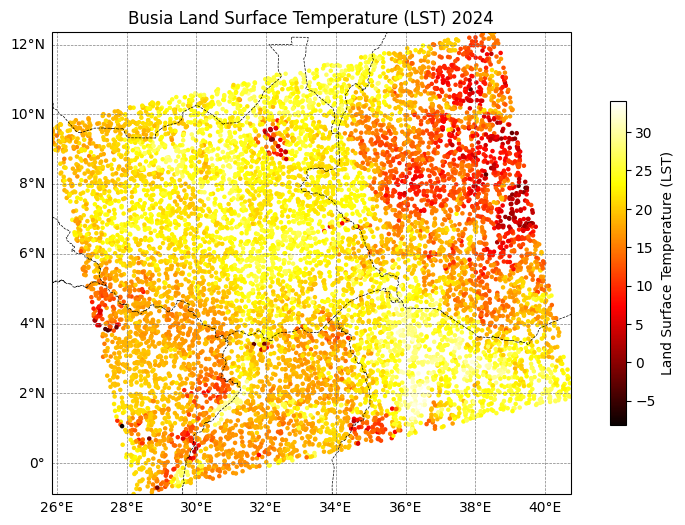

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

# Define map bounds (Modify these values as needed)
x_min, x_max = data["longitude"].min(), data["longitude"].max()
y_min, y_max = data["latitude"].min(), data["latitude"].max()

# Create a figure and axis with a Cartopy projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Add coastlines and country borders for reference
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle="--")

# Scatter plot of LST values
sc = ax.scatter(
    data["longitude"], 
    data["latitude"], 
    c=data["lst"], 
    cmap="hot",  # Use 'hot' colormap for temperature visualization
    marker="o",
    s=5,  # Point size
    transform=ccrs.PlateCarree()
)

# Add grid lines and labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", linestyle="--")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right labels
gl.xformatter = cticker.LongitudeFormatter()  # Format longitude labels
gl.yformatter = cticker.LatitudeFormatter()  # Format latitude labels

# Set x and y axis bounds
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Land Surface Temperature (LST)")

# Set title
ax.set_title("Busia Land Surface Temperature (LST) 2024")

# Show the plot
plt.show()

In [10]:
items[2]

<Item id=S3A_SL_2_LST_20241225T071421_20241225T071721_0179_120_334_2880>

### Extracting Entire Dataset

In [11]:
import planetary_computer
import pystac_client
import dask.dataframe as dd
import xarray as xr
import fsspec
import pandas as pd
import dask
from datetime import datetime

# Enable Dask for parallel computing
dask.config.set(scheduler='threads')

# Initialize STAC client
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Define parameters
collection_name = "sentinel-3-slstr-lst-l2-netcdf"
time_of_interest = "2024-12-01/2024-12-31"
aoi_bbox = [33.9, 0.1, 34.6, 0.8]  # Busia County
area_of_interest = {
    "type": "Polygon",
    "coordinates": [[
        [aoi_bbox[0], aoi_bbox[1]], [aoi_bbox[0], aoi_bbox[3]],  
        [aoi_bbox[2], aoi_bbox[3]], [aoi_bbox[2], aoi_bbox[1]],  
        [aoi_bbox[0], aoi_bbox[1]],  
    ]]
}

In [12]:
# Search the dataset
search = catalog.search(
    collections=[collection_name],
    intersects=area_of_interest, 
    datetime=time_of_interest
)
items = search.item_collection()

print(f"Found {len(items)} Sentinel-3 SLSTR LST datasets for Busia County")

Found 12 Sentinel-3 SLSTR LST datasets for Busia County


In [13]:
# Function to process a single dataset using Dask
def process_item(item):
    try:
        # Extract date from the ID
        date_str = item.id.split("_")[4][:8]  # Extract YYYYMMDD
        date = datetime.strptime(date_str, "%Y%m%d").date()

        # Load geolocation dataset
        geo = xr.open_dataset(fsspec.open(item.assets["slstr-geodetic-in"].href).open()).load()

        # Load temperature dataset
        dataset = xr.open_dataset(fsspec.open(item.assets["lst-in"].href).open(), engine="h5netcdf")

        # Convert to Dask DataFrame
        df = dd.from_pandas(
            pd.DataFrame({
                "longitude": geo.longitude_in.data.ravel(),
                "latitude": geo.latitude_in.data.ravel(),
                "temperature_C": dataset.LST.load().data.ravel() - 273.15,  # Convert Kelvin to Celsius
                "date": date
            }).dropna(),
            npartitions=3  # Set partitions for Dask
        )

        return df
    except Exception as e:
        print(f"Error processing {item.id}: {e}")
        return None

In [14]:
# Process all datasets in parallel using Dask
data_list = dask.compute(*[dask.delayed(process_item)(item) for item in items])

In [15]:
# Filter out None values (failed downloads)
data_list = [df for df in data_list if df is not None]

In [16]:
# Concatenate all Dask DataFrames
final_data = dd.concat(data_list, interleave_partitions=True)

In [17]:
final_data.head()

,longitude,latitude,temperature_C,date
27,35.564896,8.319570,25.606018,2024-12-06
28,35.564896,8.319570,25.606018,2024-12-06
29,35.577938,8.315428,24.921997,2024-12-06
30,35.584011,8.315777,24.980011,2024-12-06
31,35.596020,8.312424,24.955994,2024-12-06


In [18]:
final_data.shape

(<dask_expr.expr.Scalar: expr=(Concat(frames=[df, df, df, df, df, df, df, df, df, df, df, df], interleave_partitions=True)).size() // 4, dtype=int64>,
 4)